In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import xgboost as xgb

In [89]:
drive.mount('/content/drive')

dataset = pd.read_csv('/content/drive/MyDrive/ALU/datasets/african_crises.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
print("Dataset Preview:")
display(dataset.head())
print("\nDataset Info:")
display(dataset.info())


Dataset Preview:


,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,DZA,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,1,DZA,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,1,DZA,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,1,DZA,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,1,DZA,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   case                             1059 non-null   int64  
 1   cc3                              1059 non-null   object 
 2   country                          1059 non-null   object 
 3   year                             1059 non-null   int64  
 4   systemic_crisis                  1059 non-null   int64  
 5   exch_usd                         1059 non-null   float64
 6   domestic_debt_in_default         1059 non-null   int64  
 7   sovereign_external_debt_default  1059 non-null   int64  
 8   gdp_weighted_default             1059 non-null   float64
 9   inflation_annual_cpi             1059 non-null   float64
 10  independence                     1059 non-null   int64  
 11  currency_crises                  1059 non-null   int64  
 12  infla

None

In [91]:
print("\nUnique values in each column:")
for column in dataset.columns:
    print(f"\n{column}:", dataset[column].unique())


Unique values in each column:

case: [ 1  2 10 15 19 35 38 40 45 56 63 69 70]

cc3: ['DZA' 'AGO' 'CAF' 'CIV' 'EGY' 'KEN' 'MUS' 'MAR' 'NGA' 'ZAF' 'TUN' 'ZMB'
 'ZWE']

country: ['Algeria' 'Angola' 'Central African Republic' 'Ivory Coast' 'Egypt'
 'Kenya' 'Mauritius' 'Morocco' 'Nigeria' 'South Africa' 'Tunisia' 'Zambia'
 'Zimbabwe']

year: [1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883
 1884 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951
 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1968 1969 1970 1971
 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985
 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1962 1963 1964 1965 1966 1967 1860 1861 1862
 1863 1864 1865 1866 1867 1868 1869 1885 1886 1887 1888 1889 1890 1891
 1892 1893 1894 1895 

In [92]:
# Create numerical variables for countries
country_dummies = pd.get_dummies(dataset['country'], prefix='country')

# Convert banking_crisis to numerical
dataset['banking_crisis'] = dataset['banking_crisis'].map({"no_crisis": 0, "crisis": 1})

# Drop non essential columns
columns_to_drop = ['cc3', 'country', 'year']
dataset = dataset.drop(columns=columns_to_drop)

# Combine with country dummies
processed_data = pd.concat([dataset, country_dummies], axis=1)

In [93]:
X = processed_data.drop('banking_crisis', axis=1)
y = processed_data['banking_crisis']

In [94]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [96]:
results_table = []

In [97]:
print("\nTraining Logistic Regression model...")
lr_model = LogisticRegression(
    C=0.1,
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, lr_pred),
    'F1-score': f1_score(y_test, lr_pred),
    'Precision': precision_score(y_test, lr_pred),
    'Recall': recall_score(y_test, lr_pred),
    'ROC-AUC': roc_auc_score(y_test, lr_pred_proba)
}
results_table.append(lr_metrics)


Training Logistic Regression model...


In [98]:
print("\nTraining Simple Neural Network...")
simple_nn = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

simple_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

simple_nn_history = simple_nn.fit(
    X_train_scaled, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=0
)

simple_nn_pred = (simple_nn.predict(X_test_scaled) > 0.5).astype(int)
simple_nn_pred_proba = simple_nn.predict(X_test_scaled)


Training Simple Neural Network...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [99]:
simple_nn_metrics = {
    'Model': 'Simple Neural Network',
    'Accuracy': accuracy_score(y_test, simple_nn_pred),
    'F1-score': f1_score(y_test, simple_nn_pred),
    'Precision': precision_score(y_test, simple_nn_pred),
    'Recall': recall_score(y_test, simple_nn_pred),
    'ROC-AUC': roc_auc_score(y_test, simple_nn_pred_proba)
}
results_table.append(simple_nn_metrics)


In [100]:
# Instance 1 - Basic configuration
print("\nTraining Neural Network - Instance 1...")
nn_instance1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn_instance1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history1 = nn_instance1.fit(X_train_scaled, y_train, epochs=20, batch_size=32,
                          validation_data=(X_val_scaled, y_val), verbose=0)


Training Neural Network - Instance 1...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
nn_instance1_pred = (nn_instance1.predict(X_test_scaled) > 0.5).astype(int)
nn_instance1_pred_proba = nn_instance1.predict(X_test_scaled)

nn_instance1_metrics = {
    'Model': 'NN Instance 1',
    'Accuracy': accuracy_score(y_test, nn_instance1_pred),
    'F1-score': f1_score(y_test, nn_instance1_pred),
    'Precision': precision_score(y_test, nn_instance1_pred),
    'Recall': recall_score(y_test, nn_instance1_pred),
    'ROC-AUC': roc_auc_score(y_test, nn_instance1_pred_proba)
}
results_table.append(nn_instance1_metrics)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [102]:
print("\nTraining Neural Network - Instance 2...")
nn_instance2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn_instance2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history2 = nn_instance2.fit(X_train_scaled, y_train, epochs=30, batch_size=32,
                          validation_data=(X_val_scaled, y_val), verbose=0)


Training Neural Network - Instance 2...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [103]:
nn_instance2_pred = (nn_instance2.predict(X_test_scaled) > 0.5).astype(int)
nn_instance2_pred_proba = nn_instance2.predict(X_test_scaled)

nn_instance2_metrics = {
    'Model': 'NN Instance 2 (L2 + Dropout)',
    'Accuracy': accuracy_score(y_test, nn_instance2_pred),
    'F1-score': f1_score(y_test, nn_instance2_pred),
    'Precision': precision_score(y_test, nn_instance2_pred),
    'Recall': recall_score(y_test, nn_instance2_pred),
    'ROC-AUC': roc_auc_score(y_test, nn_instance2_pred_proba)
}
results_table.append(nn_instance2_metrics)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [104]:
print("\nTraining Neural Network - Instance 3...")
nn_instance3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3
)

nn_instance3.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history3 = nn_instance3.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                          validation_data=(X_val_scaled, y_val),
                          callbacks=[early_stopping, lr_scheduler],
                          verbose=0)


Training Neural Network - Instance 3...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [105]:
nn_instance3_pred = (nn_instance3.predict(X_test_scaled) > 0.5).astype(int)
nn_instance3_pred_proba = nn_instance3.predict(X_test_scaled)

nn_instance3_metrics = {
    'Model': 'NN Instance 3 (Early Stopping + LR Scheduler)',
    'Accuracy': accuracy_score(y_test, nn_instance3_pred),
    'F1-score': f1_score(y_test, nn_instance3_pred),
    'Precision': precision_score(y_test, nn_instance3_pred),
    'Recall': recall_score(y_test, nn_instance3_pred),
    'ROC-AUC': roc_auc_score(y_test, nn_instance3_pred_proba)
}
results_table.append(nn_instance3_metrics)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [106]:
# Create results table
print("\nResults Table:")
results_df = pd.DataFrame(results_table)
display(results_df)


Results Table:


,Model,Accuracy,F1-score,Precision,Recall,ROC-AUC
0,Logistic Regression,0.974843,0.857143,0.750000,1.000000,0.999433
1,Simple Neural Network,0.993711,0.960000,0.923077,1.000000,0.999433
2,NN Instance 1,1.000000,1.000000,1.000000,1.000000,1.000000
3,NN Instance 2 (L2 + Dropout),0.993711,0.956522,1.000000,0.916667,1.000000
4,NN Instance 3 (Early Stopping + LR Scheduler),0.993711,0.960000,0.923077,1.000000,1.000000


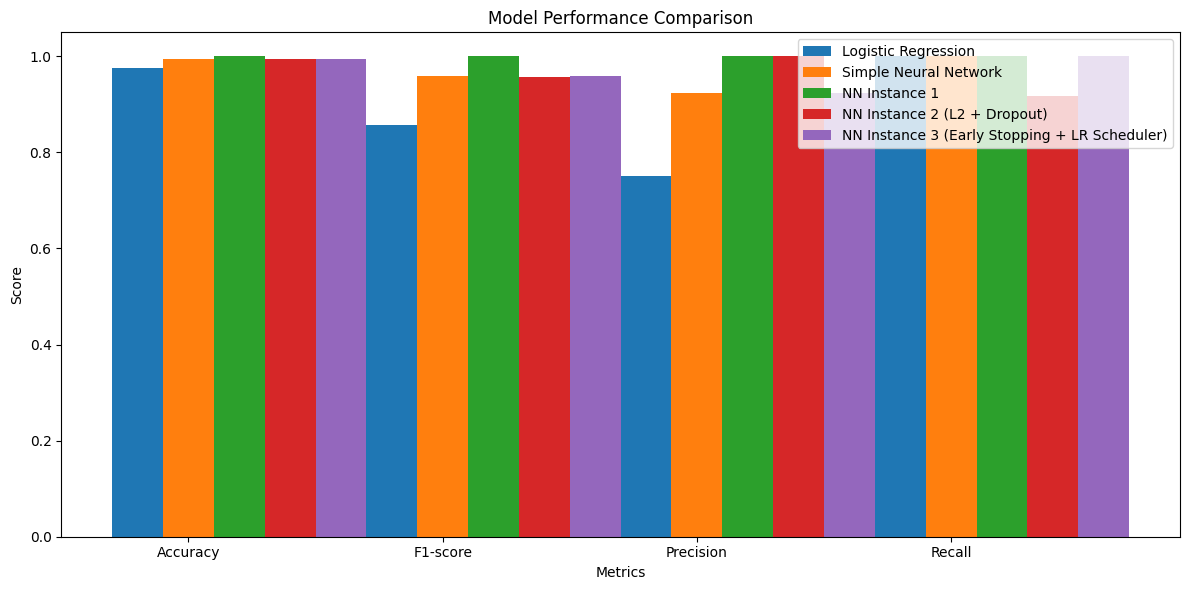

In [107]:
# Visualize results
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'F1-score', 'Precision', 'Recall']
x = np.arange(len(metrics))
width = 0.2
for i, model in enumerate(results_df['Model']):
    values = [results_df.loc[i, metric] for metric in metrics]
    plt.bar(x + i*width, values, width, label=model)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width, metrics)
plt.legend()
plt.tight_layout()
plt.show()